In [ ]:
!wget https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EQc79uRBeO1FqtH6ILFDx78BuuWui3DuRaBtnzTB6Aqxqg?download=1 -O data.tar
!tar -xvf data.tar

--2023-05-09 20:03:13--  https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EQc79uRBeO1FqtH6ILFDx78BuuWui3DuRaBtnzTB6Aqxqg?download=1
Resolving technionmail-my.sharepoint.com (technionmail-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to technionmail-my.sharepoint.com (technionmail-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ploznik_campus_technion_ac_il/Documents/HW1_data/data.tar?ga=1 [following]
--2023-05-09 20:03:14--  https://technionmail-my.sharepoint.com/personal/ploznik_campus_technion_ac_il/Documents/HW1_data/data.tar?ga=1
Reusing existing connection to technionmail-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 212420608 (203M) [application/x-tar]
Saving to: ‘data.tar’

data.tar            100%[===================>] 202.58M  63.2MB/s    in 3.2s    

2023-05-09 20:03:17 (63.2 MB/s) - ‘data.tar’ saved [2

In [1]:
import pandas as pd
import numpy as np
import os
import random 

# Set the random seed for numpy
np.random.seed(42)
# Set the random seed for Python's built-in random module
random.seed(42)

In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for directory in ["/content/data/train","/content/data/test"]:
  for filename in os.listdir(directory):
    if filename.endswith('.psv'): 
      # Load the data from the PSV file into a dataframe
      file_path = os.path.join(directory, filename)
      file_data = pd.read_csv(file_path, sep='|')
      file_data['patient'] = str(filename).split('.')[0].split('_')[1]
      if "train" in directory:
      # Append the data to the main dataframe
        index_up_to = len(file_data) - len(file_data[file_data['SepsisLabel'] == 1])
        file_data = file_data[file_data.index<=index_up_to]
        df_train = pd.concat([df_train, file_data])
      else: 
        index_up_to = len(file_data) - len(file_data[file_data['SepsisLabel'] == 1])
        file_data = file_data[file_data.index<=index_up_to]
        df_test = pd.concat([df_test, file_data])

In [ ]:
# df_train.to_csv("train_set.csv",index=False)
# df_test.to_csv("test_set.csv",index=False)

In [ ]:
def drop_redundent(df):
  df.drop(['Unit1','Unit2','ICULOS'],axis=1, inplace=True)
  return df

In [ ]:
def aggregation(df):
  freq = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
  rare = [ 'EtCO2','BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
            'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
            'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
            'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
            'Fibrinogen', 'Platelets']
  statistics = {}
  df_conc = pd.DataFrame()
  counter = 0
  for patient in df["patient"].unique():
    statistics[patient] = {}
    counter +=1
    if counter%1000 == 0:
      print(counter)
    pat_desc = df[df["patient"]==patient].describe()
    statistics[patient]['patient'] = patient
    patient_count = df[df["patient"]==patient].shape[0]
    statistics[patient]['count']=patient_count
    statistics[patient]['Age']=pat_desc["Age"][1]
    statistics[patient]['Gender']=pat_desc["Gender"][1]
    statistics[patient]['SepsisLabel']=pat_desc["SepsisLabel"][7]
    statistics[patient]['HospAdmTime']=pat_desc["HospAdmTime"][1]
    for col in freq:
      stat_list = pat_desc[col].tolist()
      statistics[patient][f"mean {col}"] = stat_list[1]
      statistics[patient][f"Q1 {col}"] = stat_list[4]
      statistics[patient][f"Q2 {col}"] = stat_list[5]
      statistics[patient][f"Q3 {col}"] = stat_list[6]
      statistics[patient][f"max {col}"] = stat_list[7]
      statistics[patient][f"min {col}"] = stat_list[3]
      statistics[patient][f"std {col}"] = stat_list[2]
      statistics[patient][f"p1 {col}"] = df[df["patient"]==patient][col].iloc[:int(patient_count/4)].mean()
      statistics[patient][f"p2 {col}"] = df[df["patient"]==patient][col].iloc[int(patient_count/4):int(patient_count/2)].mean()
      statistics[patient][f"p3 {col}"] = df[df["patient"]==patient][col].iloc[int(patient_count/2):int((3*patient_count)/4)].mean()
      statistics[patient][f"p4 {col}"] = df[df["patient"]==patient][col].iloc[int((3*patient_count)/4):int(patient_count)].mean()
    for col in rare:
      stat_list = pat_desc[col].tolist()
      statistics[patient][f"max {col}"] = stat_list[7]
      statistics[patient][f"min {col}"] = stat_list[3]
  df_conc = pd.DataFrame.from_dict(statistics,orient="index")
  return df_conc

In [3]:
def data_and_labels(df):
  #creating targets vector
  labels = []
  for patient in df["patient"].unique():
    sep_vec = df[df["patient"]==patient]["SepsisLabel"]
    if sum(sep_vec) > 0:
      labels.append(1)
    else: 
      labels.append(0)
  df = df.drop(['patient','SepsisLabel'],axis=1)
  return df.to_numpy(), np.array(labels)

In [ ]:
def categorial_imputation(df,rare):
  for col in rare:
    print(col)
    col_desc = df[col].describe()
    for patient in df["patient"]:
      # print(df[df["patient"]==patient][col])
      val = df[df["patient"]==patient][col].iloc[0]
      if val == np.nan:
        df.loc[df['patient'] == patient,col]=0
      elif val>=col_desc[3] and val<col_desc[4]:
        df.loc[df['patient'] == patient,col]= 1
      elif val>=col_desc[4] and val<col_desc[5]:
        df.loc[df['patient'] == patient,col]= 2
      elif val>=col_desc[5] and val<col_desc[6]:
        df.loc[df['patient'] == patient,col] = 3
      else:
        df.loc[df['patient'] == patient,col] = 4
  return df

In [ ]:
def mean_imputation(df):
  col_mean = df.mean()
  df_imp = df.fillna(col_mean)
  return df_imp

In [ ]:
#to create the aggregation

##train set
# df_train = pd.read_csv("/content/train_set.csv")
df_train = drop_redundent(df_train)
df_train = aggregation(df_train)
df_train = categorial_imputation(df_train)
df_train = mean_imputation(df_train)
print(df_train.shape)
df_train.to_csv("train_for_model.csv", index=False)
#
##test set
# df_test = pd.read_csv("/content/test_set.csv")
# print(len(df_train.groupby("patient").mean()))
df_test = drop_redundent(df_test)
df_test = aggregation(df_test)
df_test = categorial_imputation(df_test)
df_test = mean_imputation(df_test)
# print(df_train.shape)
df_test.to_csv("test_for_model.csv", index=False)

# or to use the exisiting one
## df_train = pd.read_csv("/content/train_for_model.csv")
## df_test = pd.read_csv("/content/test_for_model.csv")


1000
2000
3000
4000
5000
6000


In [4]:
#seperate to data and labels
df_train = pd.read_csv("/content/train_for_model.csv")
# df_test = pd.read_csv("/content/test_categorial_imp.csv")
# df_train = df_train[df_train.columns[1:]]
# df_test = df_test[df_test.columns[1:]]
# df_org_train = pd.read_csv("/content/train_set.csv")
# df_org_test = pd.read_csv("/content/test_set.csv")
X_train,y_train = data_and_labels(df_train)
# X_val, y_val = data_and_labels(df_test)

In [8]:
features = df_train.columns.tolist()
features.remove('patient')
features.remove('SepsisLabel')
len(features)

135

In [ ]:
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score,f1_score

# Best_parameters = {'objective': 'binary:logistic','eval_metric':'aucpr',
#                    'colsample_bytree': 0.7762152770114458, 'gamma': 2.2524962598477147,
#                    'learning_rate': 0.10663248057993327, 'max_depth': 7,
#                    'n_estimators': 109, 'subsample': 0.6943017524918775}
# # Define XGBoost model parameters
# # params = {
# #     'objective': 'binary:logistic',
# #     'eval_metric': 'logloss',
# #     'max_depth': 3,
# #     'eta': 0.1
# # }

# # Train XGBoost model
# dtrain = xgb.DMatrix(X_train, label=y_train)
# model = xgb.train(Best_parameters, dtrain)

# # Make predictions on test set
# dtest = xgb.DMatrix(X_val)
# y_pred = model.predict(dtest)

# # Convert probabilities to binary predictions
# y_pred_binary = [1 if p >= 0.34 else 0 for p in y_pred]

# # Evaluate model accuracy
# f1 = f1_score(y_val, y_pred_binary)
# print(f'f1 score is: {f1:.2f}')

[10:10:03] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

f1 score is: 0.70


In [32]:
###using cross validation in order to choose the hyper paraneters
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

X_train,y_train = data_and_labels(df_train_important)
# Define the parameter grid to search over
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(7, 11),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.3, 0.7),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 5),
     
    
}

# Create an XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42,tree_method='hist',eval_metric='aucpr',scale_pos_weight=93/7)

# Create a RandomizedSearchCV object with 5-fold cross-validation
rs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_dist, 
    scoring='roc_auc', n_iter=100, cv=5, n_jobs=-1, random_state=42
)

# Fit the RandomizedSearchCV object to the training data
rs.fit(X_train, y_train)
model_xgb = rs.best_estimator_
params = rs.best_params_
# y_pred = model_xgb.predict(X_val)
# Evaluate model f1_score
# f1 = f1_score(y_val, y_pred)
# print(f'F1 score is: {f1:.3f}')
# Print the best hyperparameters
print("Best parameters:",rs.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.31702117650201767, 'gamma': 3.227361479535839, 'learning_rate': 0.09855533970352447, 'max_depth': 10, 'n_estimators': 79, 'subsample': 0.9677500039018112}


In [46]:
##predict and evaluate
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, f1_score
model_xgb = xgb_model_loaded
df_test = pd.read_csv("/content/test_for_model.csv")
# df_test.drop(unimportant_feat, axis=1,inplace=True)
X_val, y_val = data_and_labels(df_test)
y_pred = model_xgb.predict_proba(X_val)

# Evaluate model accuracy
# Convert probabilities to binary predictions
best_prob = 0.1
best_f1 = 0
for prob in np.arange(0.1,0.9,0.01):
  y_pred_binary = [1 if p[1] >= prob else 0 for p in y_pred]
  f1 = f1_score(y_val, y_pred_binary)
  if f1 > best_f1:
    best_prob=prob
    best_f1=f1
  print(f'F1 score for prob={prob} is: {f1:.4f}')
y_pred_binary = [1 if p[1] >= best_prob else 0 for p in y_pred]
f1 = f1_score(y_val, y_pred_binary)
print(f'F1 score for best probabilty treshold is: {f1:.4f}')
confusion_matrix(y_val, y_pred_binary,labels=None, sample_weight=None, normalize=None)

F1 score for prob=0.1 is: 0.6099
F1 score for prob=0.11 is: 0.6232
F1 score for prob=0.12 is: 0.6339
F1 score for prob=0.13 is: 0.6445
F1 score for prob=0.13999999999999999 is: 0.6561
F1 score for prob=0.14999999999999997 is: 0.6654
F1 score for prob=0.15999999999999998 is: 0.6713
F1 score for prob=0.16999999999999998 is: 0.6774
F1 score for prob=0.17999999999999997 is: 0.6846
F1 score for prob=0.18999999999999995 is: 0.6888
F1 score for prob=0.19999999999999996 is: 0.6959
F1 score for prob=0.20999999999999996 is: 0.6999
F1 score for prob=0.21999999999999995 is: 0.7016
F1 score for prob=0.22999999999999995 is: 0.7038
F1 score for prob=0.23999999999999994 is: 0.7065
F1 score for prob=0.24999999999999992 is: 0.7091
F1 score for prob=0.2599999999999999 is: 0.7093
F1 score for prob=0.2699999999999999 is: 0.7135
F1 score for prob=0.2799999999999999 is: 0.7137
F1 score for prob=0.2899999999999999 is: 0.7169
F1 score for prob=0.29999999999999993 is: 0.7184
F1 score for prob=0.3099999999999999

array([[9135,  124],
       [ 252,  489]])

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00     18585
        sick       0.97      1.00      0.99      1415

    accuracy                           1.00     20000
   macro avg       0.99      1.00      0.99     20000
weighted avg       1.00      1.00      1.00     20000



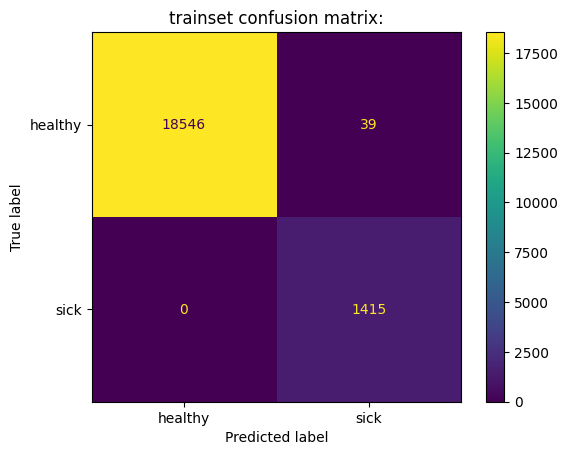

In [ ]:
# train_pred = model_xgb.predict_proba(X_train)
# train_pred_binary = [1 if p[1] >= best_prob else 0 for p in train_pred]
# print(classification_report(y_train, train_pred_binary, target_names=["healthy","sick"]))
# conf = confusion_matrix(y_train, train_pred_binary,labels=None, sample_weight=None, normalize=None)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=["healthy","sick"])
# disp.plot()
# plt.title("trainset confusion matrix:")
# plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, f1_score, accuracy_score,recall_score,classification_report

# print(classification_report(y_val, y_pred_binary, target_names=["healthy","sick"]))
# conf = confusion_matrix(y_val, y_pred_binary,labels=None, sample_weight=None, normalize=None)
# disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=["healthy","sick"])
# disp.plot()
# plt.title("testset confusion matrix:")
# plt.show()

NameError: ignored

In [44]:
import pickle
file_name = "xgb_model_correct.pkl"

# save
# pickle.dump(rs.best_estimator_, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

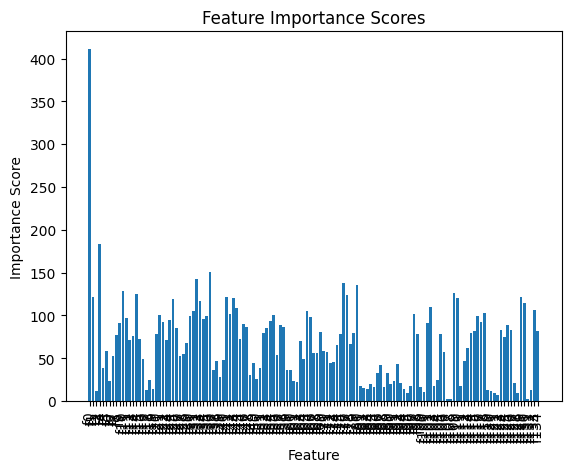

In [24]:
import matplotlib.pyplot as plt

importance = model_xgb.get_booster().get_score(importance_type='weight')
# Plot the feature importance scores
plt.bar(range(len(importance)), list(importance.values()), tick_label=list(importance.keys()))
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores')
plt.show()


In [37]:
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1]))

unimportant_feat=[]
for feat,val in list(sorted_importance.items())[:10]:
  unimportant_feat.append(features[int(feat[1:])])
# df_train_important = df_train.drop(unimportant_feat,axis=1,inplace=False)
unimportant_feat


['max Bilirubin_direct',
 'min Bilirubin_direct',
 'max Fibrinogen',
 'min TroponinI',
 'min PTT',
 'max AST',
 'max TroponinI',
 'min Alkalinephos',
 'Gender',
 'min Bilirubin_total']

In [ ]:
# def split_by_col(df,col,round_level=1):
#   splitted_data = []
#   for value in sorted(np.floor(df[col]/round_level).unique()):
#     df_temp=pd.DataFrame()
#     df_temp = df[np.floor(df[col]/round_level)==value]
#     splitted_data.append((df_temp,value*round_level))
#   return splitted_data

In [ ]:
# def post_Analysis(model,df,feature,round_level=1):
#   dfs = split_by_col(df,feature,round_level)
#   f1s = []
#   values = []
#   sizes = []
#   for group,value in dfs:
#     group_data,group_labels = data_and_labels(group)
#     g_preds = model.predict_proba(group_data)
#     g_preds = [1 if p[1] >= 0.38 else 0 for p in g_preds]
#     group_f1 = f1_score(group_labels,g_preds)
#     f1s.append(np.round(group_f1,2))
#     values.append(value)
#     sizes.append(group_labels.sum())
#   plt.bar(values, f1s,width = 0.8*round_level)
#   plt.xlabel(feature)
#   plt.ylabel("f1 score")
#   plt.title(f"f1 by value of {feature}")
#   for i, size in enumerate(sizes):
#     plt.text(values[i], max(f1s[i]-0.3,0.005), f'({size} samples)', ha='center',va='bottom', fontsize=9,rotation=90)
#   plt.show()
# # print(f"for mean Temp = {value} we got f1 score of {np.round(group_f1,2)} with {group_data.shape[0]} samples")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

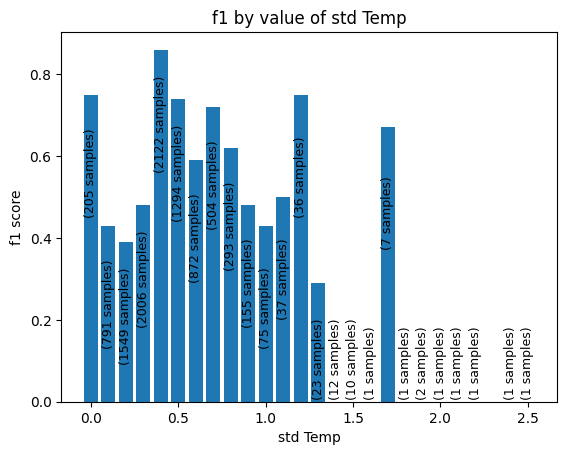

In [ ]:
# post_Analysis(xgb_model_loaded, df_test,'std Temp',0.1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


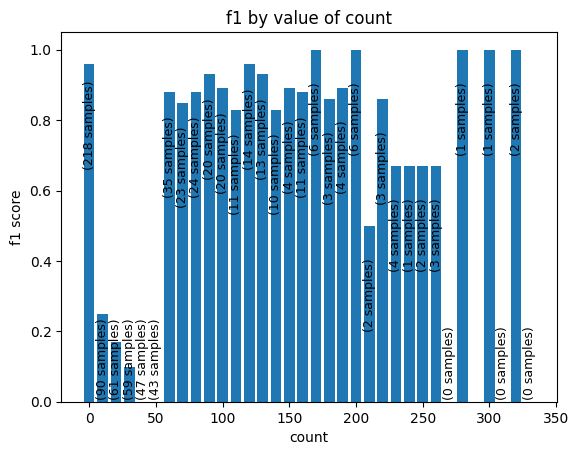

In [ ]:
# post_Analysis(xgb_model_loaded, df_test,'count',10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

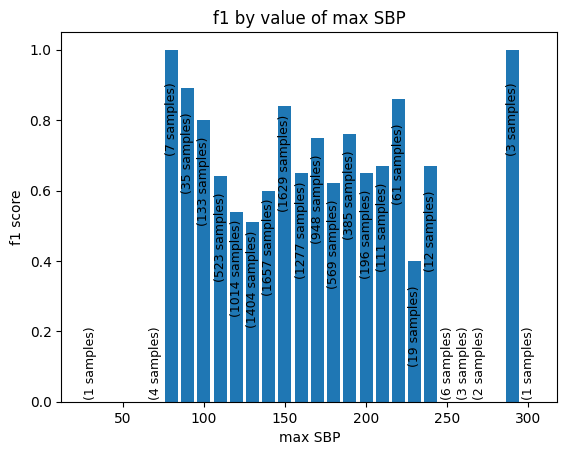

In [ ]:
# post_Analysis(xgb_model_loaded, df_test,'max SBP',10)

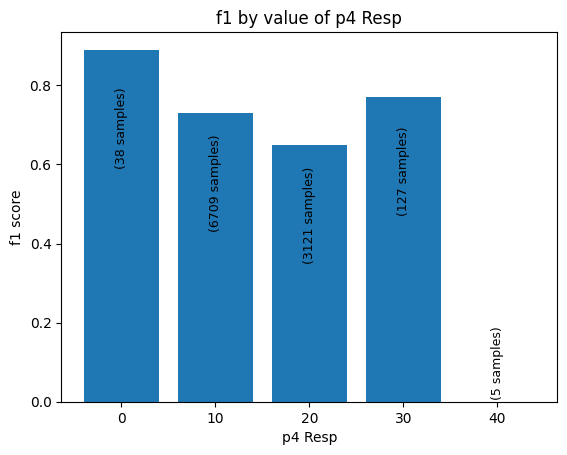

In [ ]:
# post_Analysis(xgb_model_loaded, df_test,'p4 Resp',10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


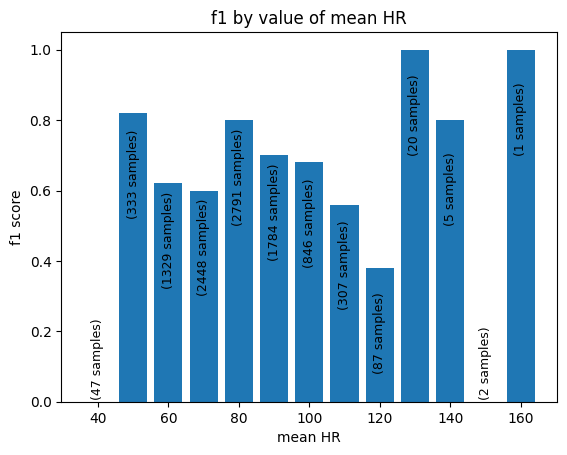

In [ ]:
# post_Analysis(xgb_model_loaded, df_test,'mean HR',10)

In [ ]:
# df_test[df_test["patient"]==100]["SepsisLabel"].item()

0.0

In [ ]:
# server_preds = pd.read_csv("/content/prediction.csv")
# true_labels = []
# preds = []
for patient in server_preds["id"]:
  # print(df_test[df_test["patient"]==patient]["SepsisLabel"])
  true_label = df_test[df_test["patient"]==patient]["SepsisLabel"].item()
  true_labels.append(true_label)
  # print(true_label)
  preds.append(server_preds[server_preds["id"]==patient]["prediction"])
print(f1_score(preds,true_labels))


0.7022653721682848


In [ ]:
# server_preds

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0
